In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from networks import SwinUnet, TransUnet, TRANSUNET_CONFIGS
from utils import *

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
CLASSES = 3
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    ToTensorV2(),
])

train_loader, val_loader, test_loader = load_origa(
    IMAGE_DIR, MASK_DIR, 0.7, 0.15, 0.15,
    train_transform, val_transform, val_transform, BATCH_SIZE,
)

Loading ORIGA dataset:
    Train size: 454 (69.85%)
    Validation size: 98 (15.08%)
    Test size: 98 (15.08%)
    
    Image shape: (3, 224, 224)
    Mask shape: (224, 224)
    Batch size: 4

    Train loader length: 114
    Validation loader length: 25
    Test loader length: 25


In [8]:
config = TRANSUNET_CONFIGS['ViT-B_16'](CLASSES)
config.n_classes = CLASSES
config.n_skip = 0
model = TransUnet(config, in_channels=3, out_channels=CLASSES, img_size=IMAGE_SIZE).to(DEVICE)
# model = SwinUnet(in_channels=3, out_channels=CLASSES, img_size=IMAGE_SIZE, patch_size=4).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [9]:
# Train the model
epochs = 5
model.train()
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(DEVICE).float()
        masks = masks.to(DEVICE).long()

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)} Loss: {loss.item()}')

Epoch 1/5
Batch 0/114 Loss: 1.0792334079742432
Batch 10/114 Loss: 0.8042885065078735
Batch 20/114 Loss: 0.7914615273475647
Batch 30/114 Loss: 0.7146187424659729
Batch 40/114 Loss: 0.7216441631317139
Batch 50/114 Loss: 0.6145526766777039
Batch 60/114 Loss: 0.918749213218689
Batch 70/114 Loss: 0.671965479850769
Batch 80/114 Loss: 0.4892347753047943
Batch 90/114 Loss: 0.5516858100891113
Batch 100/114 Loss: 0.4718019962310791
Batch 110/114 Loss: 0.511124849319458
Epoch 2/5
Batch 0/114 Loss: 0.5909737944602966
Batch 10/114 Loss: 0.4862782955169678
Batch 20/114 Loss: 0.45366156101226807
Batch 30/114 Loss: 0.6098467111587524
Batch 40/114 Loss: 0.5092942118644714
Batch 50/114 Loss: 0.5004129409790039
Batch 60/114 Loss: 0.40595743060112
Batch 70/114 Loss: 0.41103097796440125
Batch 80/114 Loss: 0.4295971393585205
Batch 90/114 Loss: 0.4691235423088074
Batch 100/114 Loss: 0.4113622009754181
Batch 110/114 Loss: 0.39039117097854614
Epoch 3/5
Batch 0/114 Loss: 0.381913423538208
Batch 10/114 Loss: 0.5

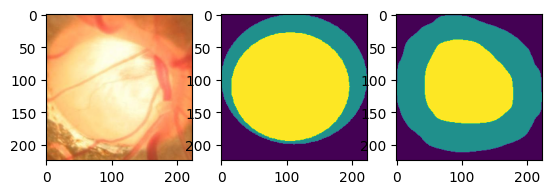

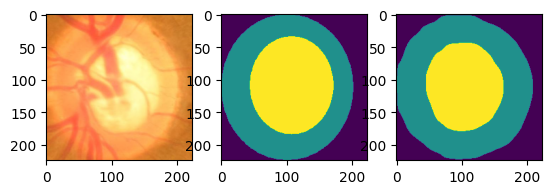

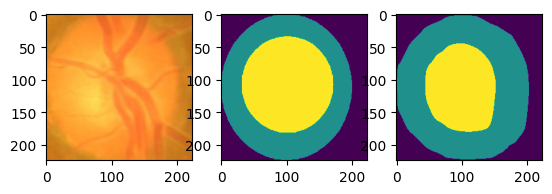

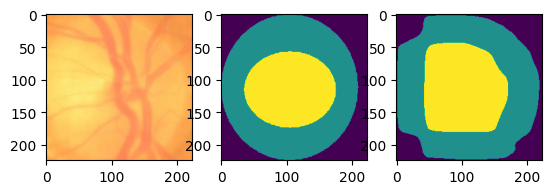

In [11]:
# Test the model
model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        images = images.to(DEVICE).float()
        masks = masks.to(DEVICE).long()

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i in range(images.shape[0]):
            fig, ax = plt.subplots(1, 3)
            ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy() / 255.0)
            ax[1].imshow(masks[i].cpu().numpy())
            ax[2].imshow(preds[i].cpu().numpy())
            plt.show()

        break